In [58]:
# importing our dependencies

import matplotlib.pyplot as plt
import hvplot.pandas
import pandas as pd
import wbdata as wb
import scipy.stats as st

In [59]:
# Read the CSVs into dataframes
df_a = pd.read_csv('Resources/inpe_brazilian_amazon_fires_1999_2019.csv')
df_b = pd.read_csv('Resources/def_area_2004_2019.csv')

# Create a mapping dictionary
state_mapping = {
    'AC': 'ACRE',
    'AM': 'AMAZONAS',
    'AP': 'AMAPA',
    'MA': 'MARANHAO',
    'MT': 'MATO GROSSO',
    'PA': 'PARA',
    'RO': 'RONDONIA',
    'RR': 'RORAIMA',
    'TO': 'TOCANTINS'
}

# Map the full state names in df_a to their initials
df_a['state_initials'] = df_a['state'].map({v: k for k, v in state_mapping.items()})

# Convert the 'year' column in both dataframes to the same type
df_a['year'] = df_a['year'].astype(str)
df_b['Ano/Estados'] = df_b['Ano/Estados'].astype(str)

# Melt df_b to long format to facilitate the merge
df_b_melted = pd.melt(df_b, id_vars=['Ano/Estados'], value_vars=state_mapping.keys(), 
                      var_name='state_initials', value_name='deforestation_area')

# Merge the two dataframes on the year and state initials
merged_df = pd.merge(df_a, df_b_melted, left_on=['year', 'state_initials'], right_on=['Ano/Estados', 'state_initials'], how='outer')

# Filter to keep only data from 2004 onwards
merged_df = merged_df[merged_df['year'] >= '2004']

# Drop the state initials column and the duplicate 'Ano/Estados' column
merged_df.drop(['state_initials', 'Ano/Estados'], axis=1, inplace=True)

merged_df.head()


,year,month,state,latitude,longitude,firespots,deforestation_area
455,2004,1,AMAPA,0.131862,-51.642086,58,46.0
456,2004,2,AMAPA,0.686000,-50.987000,1,46.0
457,2004,4,AMAPA,-0.930000,-52.327000,1,46.0
458,2004,5,AMAPA,-0.919000,-52.286000,1,46.0
459,2004,6,AMAPA,1.473857,-51.059571,7,46.0


In [60]:
def filter_by_state_and_year(df, state, year):
    """
    Filters the dataframe for the specified state and year.

    Parameters:
    - df (DataFrame): The dataframe to filter.
    - state (str): The state to filter by.
    - year (str): The year to filter by.

    Returns:
    - DataFrame: The filtered dataframe.
    """
    return df[(df['state'] == state) & (df['year'] == year)]

# Usage
desired_state = "ACRE"
desired_year = "2004"
filtered_df = filter_by_state_and_year(merged_df, desired_state, desired_year)
filtered_df


,year,month,state,latitude,longitude,firespots,deforestation_area
549,2004,2,ACRE,-8.150750,-72.611250,4,728.0
550,2004,4,ACRE,-10.887444,-68.537000,9,728.0
551,2004,5,ACRE,-9.346143,-70.787952,21,728.0
552,2004,6,ACRE,-9.390833,-69.686500,12,728.0
553,2004,7,ACRE,-9.350074,-68.990400,95,728.0
554,2004,8,ACRE,-9.649285,-68.874877,1003,728.0
555,2004,9,ACRE,-9.835523,-68.803959,5458,728.0
556,2004,10,ACRE,-10.121528,-68.810804,633,728.0
557,2004,11,ACRE,-9.150760,-70.571200,25,728.0
558,2004,12,ACRE,-10.345182,-68.199364,11,728.0


In [61]:
def fetch_co2_emissions(country):
    """
    Fetches the CO2 emissions per capita data for the specified country for the years 2004 to 2019.

    Parameters:
    - country (str): The name of the country to fetch the data for.

    Returns:
    - List of tuples: The CO2 emissions per capita data for the specified country for the years 2004 to 2019.
    """
    # Set the indicator ID for CO2 emissions per capita
    indicator_id = "EN.ATM.CO2E.PC"

    # Fetch the data for the specified country
    data = wb.get_data(indicator_id, country=country)

    # Filter and store the data for the years 2004 to 2019 in a list of tuples
    co2_emissions_data = []
    for country_data in data:
        date = country_data['date']
        if 2004 <= int(date) <= 2019:
            country = country_data['country']['value']
            value = country_data.get('value', None)  # Use the get method to handle missing data
            try:
                co2_emissions_data.append((float(value), date, country))
            except:
                pass
    
    return co2_emissions_data


In [62]:
country_codes = ['BRA', 'CHN', 'IND', 'RUS', 'ZAF']
for country_code in country_codes:
    print(fetch_co2_emissions(country_code))
    

[(2.05077012882977, '2019', 'Brazil'), (2.06426147881772, '2018', 'Brazil'), (2.18548661863967, '2017', 'Brazil'), (2.16125984748939, '2016', 'Brazil'), (2.36536062099671, '2015', 'Brazil'), (2.51459195963426, '2014', 'Brazil'), (2.4134465369818, '2013', 'Brazil'), (2.2714176835721, '2012', 'Brazil'), (2.11062775987293, '2011', 'Brazil'), (2.02660566892286, '2010', 'Brazil'), (1.79932814185315, '2009', 'Brazil'), (1.93921527398251, '2008', 'Brazil'), (1.847975735626, '2007', 'Brazil'), (1.77747795657257, '2006', 'Brazil'), (1.77566292246976, '2005', 'Brazil'), (1.77844124428615, '2004', 'Brazil')]
[(7.64543578560038, '2019', 'China'), (7.53319313353674, '2018', 'China'), (7.22616015441748, '2017', 'China'), (7.10547993572515, '2016', 'China'), (7.14513153508327, '2015', 'China'), (7.30471287157582, '2014', 'China'), (7.32015492503154, '2013', 'China'), (7.04520023039603, '2012', 'China'), (6.90134732553428, '2011', 'China'), (6.33541976743751, '2010', 'China'), (5.79831993750282, '2009

In [63]:
# Create an empty dataframe with the desired column names
co2_emissions_df = pd.DataFrame(columns=['CO2 Emissions', 'Year', 'Country'])

# Loop through the country codes and append the output of fetch_co2_emissions() to the dataframe
for country_code in country_codes:
    co2_emissions_data = fetch_co2_emissions(country_code)
    for data in co2_emissions_data:
        co2_emissions_df = pd.concat([co2_emissions_df, pd.DataFrame({'CO2 Emissions': [data[0]], 'Year': [data[1]], 'Country': [data[2]]})], ignore_index=True)

# Pivot the dataframe to have the countries as columns
co2_emissions_pivoted = co2_emissions_df.pivot(index='Year', columns='Country', values='CO2 Emissions')

co2_emissions_pivoted

Country,Brazil,China,India,Russian Federation,South Africa
Year,,,,,
2004,1.778441,3.945155,0.955470,11.112711,7.824764
2005,1.775663,4.467696,0.984261,11.231852,7.704298
2006,1.777478,4.910276,1.036534,11.568369,7.672712
2007,1.847976,5.306368,1.123599,11.611269,7.943859
2008,1.939215,5.435079,1.180361,11.595654,8.446650
2009,1.799328,5.798320,1.278874,10.832109,7.902049
2010,2.026606,6.335420,1.338034,11.325401,8.217612
2011,2.110628,6.901347,1.396878,11.884950,7.808054
2012,2.271418,7.045200,1.498204,11.702065,8.034649


In [64]:

fire_outbreak_plot = merged_df.hvplot.points('longitude',
                             'latitude',
                             geo=True,
                             color='r',
                             hover_cols = ['state', 'deforestation_area'],
                             frame_width = 800,
                             frame_height = 800, 
                             size ='firespots',
                             tiles='EsriNatGeo',
                             scale=0.1,
                             title='Fire Outbreaks Within Brazil',
                             xlabel='Longitude',
                             ylabel='Latitude',
                             alpha=0.5)

fire_outbreak_plot

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [longitude,latitude]   (firespots,state,deforestation_area)

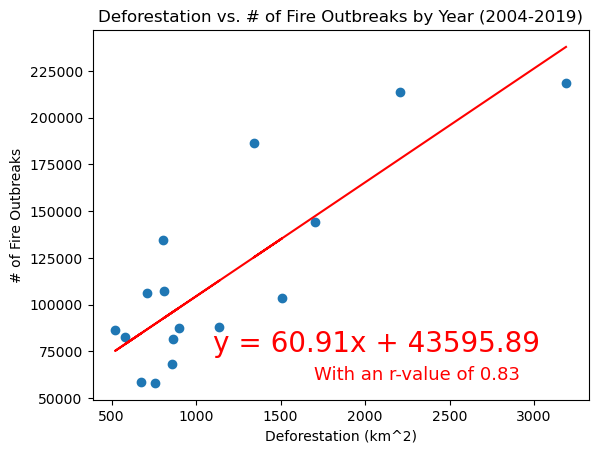

In [69]:

# Defining our comparison values
# Adding up the firespots for the year
outbreaks_sum = merged_df.groupby('year')['firespots'].sum()
# Finding the mean deforestation area for the year
deforestation_mean = merged_df.groupby('year')['deforestation_area'].mean()

# Finding values for our linear regression and the resulting fit
slope, intercept, rvalue, pvalue, stderr = st.linregress(deforestation_mean,outbreaks_sum)
fit = slope * deforestation_mean + intercept

# Creating annotated information
line_eq = f'y = {str(round(slope,2))}x + {str(round(intercept,2))}'
r_value = f'With an r-value of {round(st.pearsonr(deforestation_mean, outbreaks_sum)[0], 2)}'

# Plotting and formatting our comparison data
plt.scatter(deforestation_mean, outbreaks_sum)
plt.xlabel('Deforestation (km^2)')
plt.ylabel('# of Fire Outbreaks')
plt.title('Deforestation vs. # of Fire Outbreaks by Year (2004-2019)')
plt.plot(deforestation_mean, fit, '-', color='r')
plt.annotate(line_eq, (1100, 75000), color = 'r', fontsize = 20)
plt.annotate(r_value, (1700, 60000), color = 'r', fontsize = 13)

plt.show()
